In [ ]:
import pandas as pd
import numpy as np
# Dataviz
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from adjustText import adjust_text
# Geopatial
import geopandas as gpd
from shapely.geometry import box
import contextily as cx
import pygris.utils
import pygris
import osmnx as ox
# IO
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

## Data

### GTFS Data from Cal ITP

https://gtfs.org/getting-started/what-is-GTFS/

In [96]:
def fetch_gdf(url, offset, chunksize):
    params = {
        "outFields": "*",
        "where": "1=1",
        "f": "geojson",
        "resultOffset": offset,
        "resultRecordCount": chunksize,
    }
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        return gpd.read_file(response.text)
    except Exception as e:
        print(f"Failed at offset {offset}: {e}")
        return gpd.GeoDataFrame()

def paginate_api(url):
    CHUNK_SIZE = 2000
    MAX_WORKERS = 10
    # Get total record count
    count_url = url + "?where=1=1&returnCountOnly=true&f=json"
    max_records = requests.get(count_url).json()["count"]
    print(f"Total records: {max_records}")
    # Download in parallel with TQDM
    offsets = list(range(0, max_records, CHUNK_SIZE))
    gdfs = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {
            executor.submit(fetch_gdf, url, offset, CHUNK_SIZE): offset
            for offset in offsets
        }
        for future in tqdm(
            as_completed(futures), total=len(futures), desc="Downloading"
        ):
            gdf = future.result()
            gdfs.append(gdf)
    # Combine all chunks
    full_gdf = gpd.GeoDataFrame(
        pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs if gdfs else None
    )
    # Final output
    print(f"Final GeoDataFrame shape: {full_gdf.shape}")
    assert full_gdf.shape[0] == max_records
    return full_gdf

In [97]:
all_stops = "https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHrailroad/CA_Transit_Stops/FeatureServer/0/query"
gdf_all = paginate_api(all_stops)

Total records: 132779


Downloading: 100%|██████████| 67/67 [00:07<00:00,  9.45it/s]

Final GeoDataFrame shape: (132779, 14)


In [98]:
gdf_all[['district_name', 'agency', 'stop_id', 'n_routes', 'stop_name', 'n_arrivals', 'geometry']].head()

,district_name,agency,stop_id,n_routes,stop_name,n_arrivals,geometry
0,11 - San Diego,San Diego Metropolitan Transit System,98126,1,Hwy 94 & Honey Springs Rd,5,POINT (-116.82489 32.66927)
1,11 - San Diego,San Diego Metropolitan Transit System,98126,1,Hwy 94 & Honey Springs Rd,5,POINT (-116.82489 32.66927)
2,11 - San Diego,Flagship Cruises and Events Inc.,10176,1,Balboa Av & Ruffin Rd,6,POINT (-117.12875 32.8222)
3,11 - San Diego,San Diego International Airport,10176,1,Balboa Av & Ruffin Rd,6,POINT (-117.12875 32.8222)
4,11 - San Diego,San Diego Metropolitan Transit System,10176,1,Balboa Av & Ruffin Rd,6,POINT (-117.12875 32.8222)


In [99]:
gdf_all = gdf_all.drop_duplicates(subset='geometry')

In [ ]:
gdf_all[gdf_all['stop_name'] == 'San Pablo Av & Dwight Way'].explore(
    style_kwds=dict(fillOpacity=0.7, radius=12, color='red')
    )

### Census shapes with `pygris`

https://walker-data.com/census-r/census-geographic-data-and-applications-in-r.html

In [101]:
state_shapes = pygris.states(cache=True, year=2024)
california = state_shapes[state_shapes["GEOID"] == "06"]
california = california.set_index("NAME")
california

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,LSAD,ALAND,AWATER,geometry
NAME,,,,,,,,,
California,06,01779778,0400000US06,06,CA,00,403673433805,20291632828,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."


In [102]:
county_shapes = pygris.counties(state="06", year='2024', cache=True)
county_shapes[['NAMELSAD', 'geometry']].head()

,NAMELSAD,geometry
8,Sierra County,"POLYGON ((-120.55587 39.50874, -120.55614 39.5..."
324,Sacramento County,"POLYGON ((-121.43991 38.25553, -121.44002 38.2..."
328,Santa Barbara County,"MULTIPOLYGON (((-120.58226 34.10752, -120.5790..."
345,Calaveras County,"POLYGON ((-120.6318 38.34603, -120.63066 38.34..."
393,Ventura County,"MULTIPOLYGON (((-119.63607 33.28071, -119.6348..."


### Dealing with Coordinate Reference Systems

> A spatial reference system (SRS) or coordinate reference system (CRS) is a framework used to precisely measure locations on the surface of Earth as coordinates. It is thus the application of the abstract mathematics of coordinate systems and analytic geometry to geographic space.
https://en.wikipedia.org/wiki/Spatial_reference_system


https://docs.qgis.org/3.40/en/docs/gentle_gis_introduction/coordinate_reference_systems.html

the data from the state come in one of the most common and versatile coordinate reference systems (CRS), [World Geodetic System (WGS) 84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84), also known as [`EPSG:4326`](https://epsg.io/4326?utm_source=chatgpt.com).  

"Commonly used by organizations that provide GIS data 
for the entire globe or many countries. CRS used by Google 
Earth"

In [103]:
gdf_all.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Whereas the Tigris data come in the [North American Datum (NAD) 84](https://en.wikipedia.org/wiki/North_American_Datum), also known as [`EPSG:4269`](https://epsg.io/4269), a geodetic system commonly used by U.S. Federal Agencies.

In [104]:
california.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

I'm going to do some analysis within the U.S., so I'll work in the NAD83 CRS. CRS conversion is straightforward in geopandas:

In [105]:
target_crs = california.crs
gdf_all.crs = target_crs

In [106]:
assert gdf_all.crs == california.crs
print(gdf_all.crs, "==", california.crs)

EPSG:4269 == EPSG:4269


| Purpose          | CRS Name (w/ Wikipedia Link)                   | EPSG | Type       | Units   | Region/Use Case   | Organizations / Notes                                                             |
| ---------------- | -------------------------- | ---- | ---------- | ------- | ----------------- | --------------------------------------------------------------------------------- |
| Plotting         | [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84)                     | 4326 | Geographic | Degrees | Global            | Used globally for web and GPS data, published and maintained by the U.S. Department of Defense.                  |                                     |
| Plotting | [NAD83](https://en.wikipedia.org/wiki/North_American_Datum#)                      | 4269 | Geographic | Degrees | North America     | US Census Bureau, USGS; preferred for U.S. datasets                               |
| Web Mapping      | [WGS 84 / Pseudo-Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection#)   | 3857 | Projected  | Meters  | Global (web only) | Default for web maps (Leaflet, Mapbox); **distorts area and distance -- exercise caution!**                |
| Spatial Analysis | NAD83 / California Albers  | 3310 | Projected  | Meters  | California        | CA state agencies, minimizes distortion across the state                          |


In [107]:
gdf_ca = gdf_all.copy().sjoin(california, how="inner", predicate="within")

## Plotting Distributions

Here we have the raw data

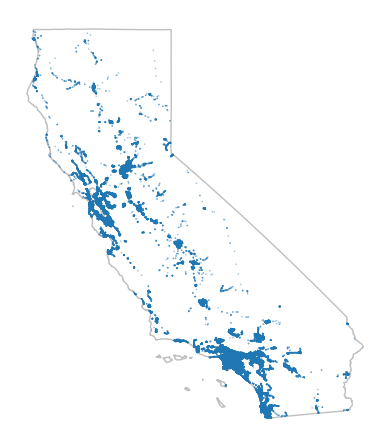

In [108]:
fig, ax = plt.subplots(figsize=(4, 5))
assert california.crs == gdf_ca.crs
california.plot(ax=ax, edgecolor="grey", facecolor="none", linewidth=1, zorder=-1, alpha=.5)
gdf_ca.plot(ax=ax, markersize=1.5, alpha=0.4, edgecolor="none", linewidth=0.05)
ax.axis("off")
fig.tight_layout()

### Aggregate with Geographic Entities

Lets aggregate up to the county level

In [109]:
def build_cmap(
    mpl_name: str = "coolwarm",
    start: float = 0.0,
    end: float = 1.0,
    int_gran: int = 1000,
) -> LinearSegmentedColormap:
    """
    Create a customized linear colormap by truncating an existing Matplotlib colormap.

    Parameters
    ----------
    mpl_name : str, default="coolwarm"
        The name of a Matplotlib colormap. See the full list at:
        https://matplotlib.org/stable/gallery/color/colormap_reference.html

    start : float, default=0
        The starting position in the original colormap's range [0, 1].

    int_gran : int, default=1000
        The number of discrete color samples to generate from the truncated colormap.
        Higher values yield smoother gradients.

    Returns
    -------
    LinearSegmentedColormap
        A new colormap instance truncated from the original, beginning at `start`.

    Raises
    ------
    AssertionError
        If `start` is not between 0 and 1 (inclusive).

    Examples
    --------
    >>> cmap = build_cmap("viridis", start=0.2)
    >>> plt.imshow(data, cmap=cmap)
    """
    assert (start <= 1) & (start >= 0), "start must be real number in [0, 1]"
    cmap = mpl.colormaps.get_cmap(mpl_name)
    new_cmap = LinearSegmentedColormap.from_list(
        "deep_reds", cmap(np.linspace(start, end, int_gran))
    )
    return new_cmap

In [110]:
def points_in_polygon(
    point_gdf: gpd.GeoDataFrame,
    polygon_gdf: gpd.GeoDataFrame,
    group_var: str,
    weight_var: str = None,
) -> gpd.GeoDataFrame:
    # Ensure CRS match
    assert point_gdf.crs == polygon_gdf.crs, f"{point_gdf.crs} != {polygon_gdf.crs}"
    # Spatial join: assign each stop to a county
    joined = point_gdf.sjoin(polygon_gdf, how="inner", predicate="within")
    # Aggregate by county
    if weight_var:
        agg = joined.groupby(group_var)[weight_var].sum().to_frame(f"{weight_var}_sum")
        result = polygon_gdf.copy()
        result = result.merge(agg, left_on=group_var, right_index=True, how="left")
    else:
        counts = joined.groupby(group_var).size().to_frame("count")
        result = polygon_gdf.copy()
        result = result.merge(counts, left_on=group_var, right_index=True, how="left")
    return result

In [111]:
def number_suffix_formatter(x, pos=None):
    """
    Formats numbers using k (thousand) and m (million) suffixes.
    
    Parameters:
        x (float or int): Number to format.
        pos: Ignored, included for compatibility with matplotlib's FuncFormatter.

    Returns:
        str: Formatted string.
    """
    thresholds = [
        (1e9, 'b'),
        (1e6, 'm'),
        (1e3, 'k'),
    ]

    for threshold, suffix in thresholds:
        if x >= threshold:
            value = x / threshold
            return f"{value:.1f}{suffix}" if x % threshold else f"{int(value)}{suffix}"

    return str(int(x))

#### Tip: change `matplotlib`'s font

In [112]:
default_font = plt.rcParams["font.family"]
default_font

['Arial']

In [113]:
pd.Series(mpl.font_manager.get_font_names()).sort_values()

191                Agency FB
47                Albany AMT
231                 Algerian
119                    Arial
94     Arial Rounded MT Bold
               ...          
37                    cmss10
32                    cmsy10
205                   cmtt10
148                 pdficons
141                sas-icons
Length: 233, dtype: object

In [114]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.family"]

['Arial']

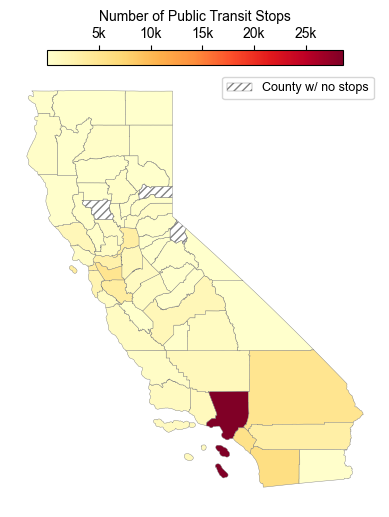

In [115]:
# Legend
new_cmap = build_cmap("YlOrRd", start=0, end=1)
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.8,
    "label": "Number of Public Transit Stops",
    "location": "top",
    "pad": 0.01,
}
# General County Style
borders_kws = {"edgecolor": "grey", "linewidth": 0.3}
data_fill_kws = {"alpha": 1, "cmap": new_cmap}
# Missing County Style
missing_fill_kws = {"hatch": "////", "facecolor": "none"}
missing_patch = Patch(**borders_kws, **missing_fill_kws, label="County w/ no stops")

fig, ax = plt.subplots(figsize=(4, 6))
county_agg = points_in_polygon(gdf_all, county_shapes, group_var="NAME")
county_agg.plot(
    column="count",
    **borders_kws,
    **data_fill_kws,
    ax=ax,
    legend=True,
    legend_kwds=legend_cbar_kws,
)
county_agg[county_agg["count"].isna()].plot(**missing_fill_kws, **borders_kws, ax=ax)
ax.legend(handles=[missing_patch], fontsize=9)
ax.axis("off")
fig.tight_layout()

### Aggregate with Geospatial Histograms

In [116]:
def histogram_to_geodataframe(hist, x_edges, y_edges, crs=None):
    """
    Convert a 2D histogram and bin edges into a GeoDataFrame of grid cells with counts.

    Parameters:
    ----------
    hist : 2D numpy array
        The histogram values (as returned by geospatial_histogram, already transposed).
    x_edges : 1D numpy array
        Bin edges along the x-axis.
    y_edges : 1D numpy array
        Bin edges along the y-axis.
    crs : any (optional)
        Coordinate reference system for the GeoDataFrame.

    Returns:
    -------
    gdf : GeoDataFrame
        A GeoDataFrame with one polygon per grid cell, with a 'count' column.
    """
    rows, cols = hist.shape
    polygons = []
    counts = []

    for i in range(rows):
        for j in range(cols):
            count = hist[i, j]
            if count == 0:
                continue  # Skip empty cells for efficiency
            x0 = x_edges[j]
            x1 = x_edges[j + 1]
            y0 = y_edges[i]
            y1 = y_edges[i + 1]
            polygons.append(box(x0, y0, x1, y1))
            counts.append(count)

    gdf = gpd.GeoDataFrame({"count": counts, "geometry": polygons}, crs=crs)
    return gdf


def geospatial_histogram(gdf, cell_size, bounds=None, weights=None):
    """
    Create a 2D geospatial histogram (raster grid of counts) from a GeoDataFrame of points.

    Parameters:
    ----------
    gdf : GeoDataFrame
        Must contain Point geometries in a projected CRS (e.g. meters).
    cell_size : float
        Width and height of grid cells (in CRS units, e.g. meters).
    bounds : tuple or None
        Optional (minx, miny, maxx, maxy). If None, computed from gdf.bounds.

    Returns:
    -------
    hist : 2D numpy array
        Histogram counts of points per grid cell.
    (Optional) x_edges, y_edges : 1D numpy arrays
        Bin edges in x and y directions.
    """
    assert gdf.crs.is_projected, "CRS must be projected first, e.g. `gdf.set_crs()`"
    if gdf.empty:
        raise ValueError("Input GeoDataFrame is empty.")
    if not gdf.geometry.geom_type.isin(["Point"]).all():
        raise ValueError("All geometries must be Points.")

    x = gdf.geometry.x.values
    y = gdf.geometry.y.values

    if weights is not None:
        weights = np.asarray(gdf[weights])
        if len(weights) != len(gdf):
            raise ValueError("Length of weights must match number of points in gdf.")

    if bounds is None:
        minx, miny, maxx, maxy = gdf.total_bounds
    else:
        minx, miny, maxx, maxy = bounds
    # Define bin edges
    x_bins = np.arange(minx, maxx + cell_size, cell_size)
    y_bins = np.arange(miny, maxy + cell_size, cell_size)
    # Compute histogram
    hist, x_edges, y_edges = np.histogram2d(
        x, y, bins=[x_bins, y_bins], weights=weights
    )
    # histogram2d returns shape (len(x_bins)-1, len(y_bins)-1) with axes (x, y)
    # Transpose so that rows = y, columns = x (like image/raster orientation)
    hist = hist.T
    return histogram_to_geodataframe(hist, x_edges, y_edges, crs=gdf.crs)

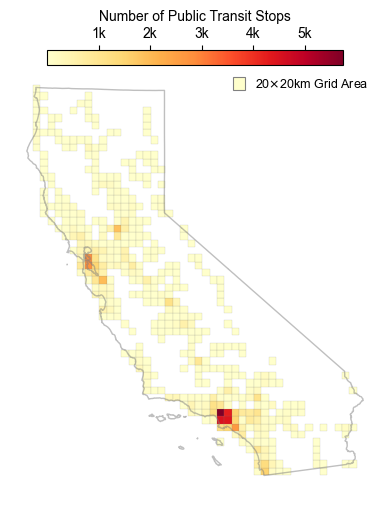

In [117]:
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.8,
    "label": "Number of Public Transit Stops",
    "location": "top",
    "pad": 0.001,
}
square_patch = mpatches.Rectangle(
    (0, 0), 10, 10, facecolor=new_cmap.get_under(), edgecolor="grey", linewidth=0.8
)
borders_kws = {"edgecolor": "grey", "linewidth": 0.1}


cell_size = 20_000
gdf_ca_proj = gdf_ca.to_crs("EPSG:3310")
california_proj = california.to_crs("EPSG:3310")
assert gdf_ca_proj.crs == california_proj.crs
arrivals_hist = geospatial_histogram(
    gdf_ca_proj, weights=None, cell_size=cell_size
)
assert arrivals_hist.crs == california_proj.crs

fig, ax = plt.subplots(figsize=(4, 6))
california_proj.plot(
    ax=ax, edgecolor="grey", facecolor="none", linewidth=1, alpha=0.5
)
arrivals_hist.plot(
    column="count",
    ax=ax,
    **data_fill_kws,
    **borders_kws,
    zorder=-1,
    legend=True,
    legend_kwds=legend_cbar_kws,
)
ax.legend(
    handles=[square_patch],
    labels=[rf"{int(cell_size/1000)}$\times${int(cell_size/1000)}km Grid Area"],
    loc="upper right",
    frameon=False,
    fontsize=9,
    handlelength=1.0,
    handleheight=1.25,
)
ax.axis("off")
fig.tight_layout()

### Aggregate with Custom Regions

In [118]:
# https://census.ca.gov/regions/
county_to_region = {
    "Butte": "Superior California",
    "Colusa": "Superior California",
    "El Dorado": "Superior California",
    "Glenn": "Superior California",
    "Lassen": "Superior California",
    "Modoc": "Superior California",
    "Nevada": "Superior California",
    "Placer": "Superior California",
    "Plumas": "Superior California",
    "Sacramento": "Superior California",
    "Shasta": "Superior California",
    "Sierra": "Superior California",
    "Siskiyou": "Superior California",
    "Sutter": "Superior California",
    "Tehama": "Superior California",
    "Yolo": "Superior California",
    "Yuba": "Superior California",
    "Del Norte": "North Coast",
    "Humboldt": "North Coast",
    "Lake": "North Coast",
    "Mendocino": "North Coast",
    "Napa": "North Coast",
    "Sonoma": "North Coast",
    "Trinity": "North Coast",
    "Alameda": "San Francisco Bay Area",
    "Contra Costa": "San Francisco Bay Area",
    "Marin": "San Francisco Bay Area",
    "San Francisco": "San Francisco Bay Area",
    "San Mateo": "San Francisco Bay Area",
    "Santa Clara": "San Francisco Bay Area",
    "Solano": "San Francisco Bay Area",
    "Alpine": "Northern San Joaquin Valley",
    "Amador": "Northern San Joaquin Valley",
    "Calaveras": "Northern San Joaquin Valley",
    "Madera": "Northern San Joaquin Valley",
    "Mariposa": "Northern San Joaquin Valley",
    "Merced": "Northern San Joaquin Valley",
    "Mono": "Northern San Joaquin Valley",
    "San Joaquin": "Northern San Joaquin Valley",
    "Stanislaus": "Northern San Joaquin Valley",
    "Tuolumne": "Northern San Joaquin Valley",
    "Monterey": "Central Coast",
    "San Benito": "Central Coast",
    "San Luis Obispo": "Central Coast",
    "Santa Barbara": "Central Coast",
    "Santa Cruz": "Central Coast",
    "Ventura": "Central Coast",
    "Fresno": "Southern San Joaquin Valley",
    "Inyo": "Southern San Joaquin Valley",
    "Kern": "Southern San Joaquin Valley",
    "Kings": "Southern San Joaquin Valley",
    "Tulare": "Southern San Joaquin Valley",
    "Riverside": "Inland Empire",
    "San Bernardino": "Inland Empire",
    "Los Angeles": "Los Angeles",
    "Orange": "Orange County",
    "Imperial": "San Diego-Imperial",
    "San Diego": "San Diego-Imperial",
}

In [119]:
county_shapes["region"] = county_shapes["NAME"].map(county_to_region)
regions = county_shapes.dissolve(by="region")
assert county_shapes.crs == regions.crs

In [120]:
def split_name_middle(name):
    parts = name.replace("-", " ").split()
    if len(parts) <= 1:
        return name  # nothing to split
    mid = len(parts) // 2
    # Insert newline at the midpoint between words
    return " ".join(parts[:mid]) + "\n" + " ".join(parts[mid:])

In [121]:
def label_polygon(
    gdf: gpd.GeoDataFrame,
    ax,
    column: str,
    adjust_list: list = [],
    adjust_kws={},
    text_kws={},
):
    texts = []
    for idx, row in gdf.iterrows():
        if row["geometry"].is_empty or row["geometry"].centroid.is_empty:
            continue
        point = row["geometry"].centroid
        x, y = point.x, point.y
        if row[column] in adjust_list:
            texts.append(ax.text(x, y, split_name_middle(row[column]), **text_kws))
        else:
            ax.text(x, y, split_name_middle(row[column]), **text_kws)
    adjust_text(texts, ax=ax, **adjust_kws)

In [122]:
new_cmap = build_cmap("coolwarm_r", start=0.1, end=0.9)
borders_kws = {"edgecolor": "grey", "linewidth": 0.3}
data_fill_kws = {"alpha": 0.7, "cmap": new_cmap}
missing_fill_kws = {"hatch": "////", "facecolor": "none"}

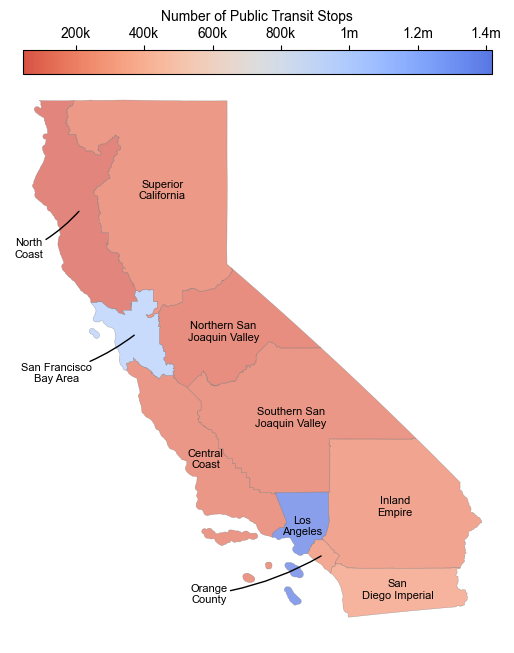

In [123]:
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.7,
    "label": "Number of Public Transit Stops",
    "location": "top",
    "pad": 0.001,
}
adjust_kws = {
    "avoid_self": True,
    "expand": (7, 3),
    "arrowprops": {
        "arrowstyle": "-",
        "color": "black",
        "lw": 1,
        "connectionstyle": "arc3,rad=0.1",
    },
}

text_kws = {
    "fontsize": 8,
    "ha": "center",
    "va": "center",
    "color": "black",
}

fig, ax = plt.subplots(figsize=(7, 7))
arrivals_in_regions = points_in_polygon(
    gdf_all,
    regions.reset_index(),
    group_var="region",
    weight_var="n_arrivals",
)
arrivals_in_regions.plot(
    column="n_arrivals_sum",
    ax=ax,
    **data_fill_kws,
    **borders_kws,
    legend=True,
    legend_kwds=legend_cbar_kws
)
label_polygon(
    arrivals_in_regions,
    ax,
    "region",
    adjust_list=["San Francisco Bay Area", "Orange County", "North Coast"],
    adjust_kws=adjust_kws,
    text_kws=text_kws,
)
ax.axis("off")
fig.tight_layout()

## Adding Context

In [124]:
hq_stops = "https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHrailroad/CA_HQ_Transit_Stops/FeatureServer/0/query"
gdf_hq = paginate_api(hq_stops)
gdf_hq = gdf_hq[~gdf_hq['hqta_details'].str.contains('planned')]

Total records: 66412


Downloading: 100%|██████████| 34/34 [00:03<00:00,  8.71it/s]

Final GeoDataFrame shape: (66412, 15)


In [125]:
gdf_hq = gdf_hq[gdf_hq['hqta_type'].str.contains('major_stop')]
gdf_hq = gdf_hq.drop_duplicates(subset='geometry')

In [126]:
gdf_hq[['hqta_type', 'stop_id', 'hqta_details','avg_trips_per_peak_hr', 'geometry']].head()

,hqta_type,stop_id,hqta_details,avg_trips_per_peak_hr,geometry
4000,major_stop_rail,13603,major_stop_rail_single_operator,3,POINT (-122.50427 37.73797)
4001,major_stop_rail,13715,major_stop_rail_single_operator,0,POINT (-122.45892 37.71319)
4002,major_stop_rail,13716,major_stop_rail_single_operator,0,POINT (-122.45916 37.71315)
4003,major_stop_rail,13717,major_stop_rail_single_operator,0,POINT (-122.46233 37.71318)
4004,major_stop_rail,13718,major_stop_rail_single_operator,0,POINT (-122.45593 37.71322)


In [127]:
gdf_hq.crs = regions.crs

In [128]:
print("Total Public Transit Stops:", gdf_all.shape[0])
print("High Quality Public Transit Stops:", gdf_hq.shape[0])

Total Public Transit Stops: 91175
High Quality Public Transit Stops: 10396


In [129]:
assert gdf_hq.crs == regions.crs
gdf_bay_hq = gdf_hq.copy()[gdf_hq.geometry.within(regions.loc["San Francisco Bay Area"].geometry)]

In [130]:
sf_bay_county_shapes = county_shapes[county_shapes["region"] == "San Francisco Bay Area"]

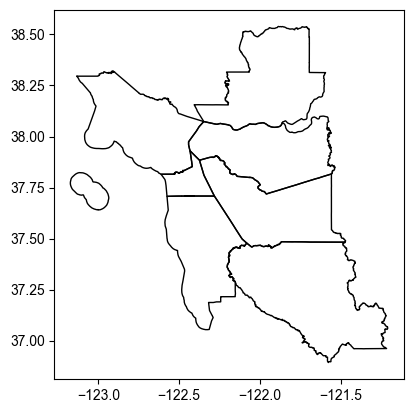

In [131]:
sf_bay_county_shapes.plot(facecolor="none");

In [132]:
exploded_shapes = (
    sf_bay_county_shapes
    .explode(index_parts=True, ignore_index=True)
    .reset_index(names='shape_index')
)
assert sf_bay_county_shapes.crs == exploded_shapes.crs
print("Pre-explosion shape", sf_bay_county_shapes.shape)
print("Post-explosion shape", exploded_shapes.shape)

Pre-explosion shape (7, 20)
Post-explosion shape (8, 21)


In [133]:
exploded_shapes = points_in_polygon(gdf_bay_hq, exploded_shapes, "shape_index")
assert exploded_shapes.crs == sf_bay_county_shapes.crs

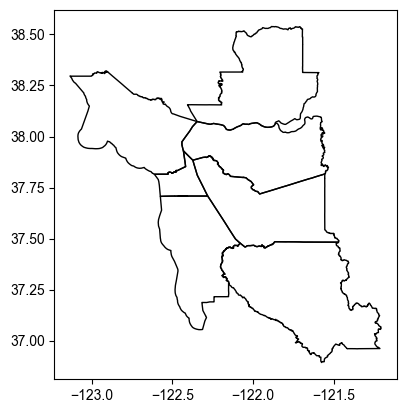

In [134]:
sf_bay_county_shapes = exploded_shapes[exploded_shapes['count'] > 0]
sf_bay_county_shapes.plot(facecolor="none");

In [136]:
bay_area_no_water = pygris.utils.erase_water(
    sf_bay_county_shapes,
    year=2024,
    cache=True
)
assert bay_area_no_water.crs == sf_bay_county_shapes.crs

HTTP download failed, trying FTP as fallback...


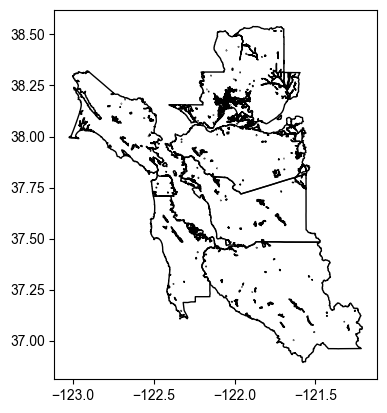

In [137]:
bay_area_no_water.plot(facecolor="none");

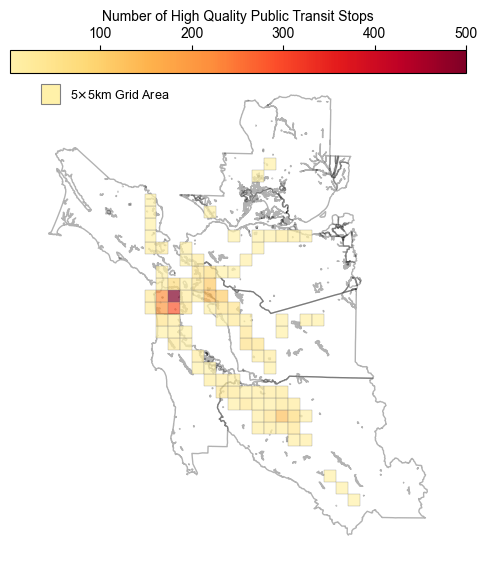

In [138]:
# Dataset
cell_size = 5_000
gdf_bay_proj= gdf_bay_hq.to_crs("EPSG:3310")
bay_area_no_water_proj= bay_area_no_water.to_crs("EPSG:3310")
assert gdf_bay_proj.crs == bay_area_no_water_proj.crs
bay_arrivals_hist = geospatial_histogram(
    gdf_bay_proj, weights=None, cell_size=cell_size
)
assert bay_arrivals_hist.crs == bay_area_no_water_proj.crs

# Style
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.8,
    "label": "Number of High Quality Public Transit Stops",
    "location": "top",
    "pad": 0.001,
}
new_cmap = build_cmap("YlOrRd", 0.1)
borders_kws = {"edgecolor": "grey", "linewidth": 0.3}
data_fill_kws = {"alpha": 0.7, "cmap": new_cmap}
square_patch = mpatches.Rectangle(
    (0, 0), 10, 10, facecolor=new_cmap.get_under(), edgecolor="grey", linewidth=0.8
)
#Plotting
fig, ax = plt.subplots(figsize=(6, 6))
bay_area_no_water_proj.plot(
    ax=ax, edgecolor="black", facecolor="none", linewidth=1, alpha=0.3, zorder=-1
)
bay_arrivals_hist.plot(
    column="count",
    ax=ax,
    **data_fill_kws,
    **borders_kws,
    vmax=500,
    legend=True,
    legend_kwds=legend_cbar_kws,
)
ax.legend(
    handles=[square_patch],
    labels=[rf"{int(cell_size/1000)}$\times${int(cell_size/1000)}km Grid Area"],
    loc="upper left",
    frameon=False,
    fontsize=9,
    handlelength=1.5,
    handleheight=2,
)
ax.axis("off")
fig.tight_layout()

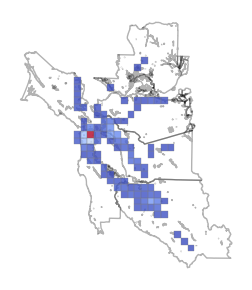

In [139]:
fig, ax = plt.subplots(figsize=(3, 3))
bay_arrivals_hist.plot(column='count', ax=ax, cmap='coolwarm', alpha=.8,
    **borders_kws)
bay_area_no_water_proj.plot(
    ax=ax, edgecolor="black", facecolor="none", linewidth=1, alpha=0.3, zorder=-1
)
# ax.set_ylim(bay_arrivals_hist.total_bounds[1] + 6e4 , bay_arrivals_hist.total_bounds[3] - 6e4)
# ax.set_xlim(bay_arrivals_hist.total_bounds[0] + 1e4 , bay_arrivals_hist.total_bounds[2] - 1e4)
ax.axis("off")
fig.tight_layout()
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=300)

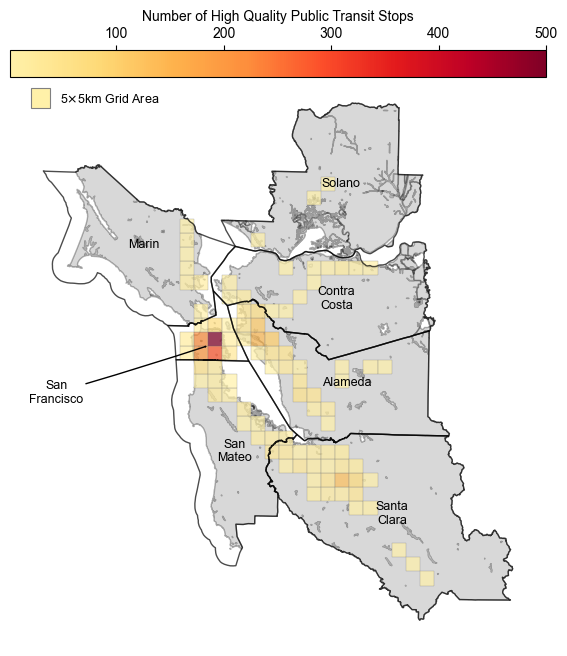

In [140]:
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.8,
    "label": "Number of High Quality Public Transit Stops",
    "location": "top",
    "pad": 0.001,
}
adjust_kws = {
    "avoid_self": True,
    "expand": (7, 3),
    "arrowprops": {
        "arrowstyle": "->",
        "color": "black",
        "lw": 1,
        "connectionstyle": "arc3,rad=0.01",
    },
}

text_kws = {"fontsize": 9, "ha": "center", "va": "center", "color": "black"}
cell_size = 5_000
square_patch = mpatches.Rectangle(
    (0, 0), 10, 10, facecolor=new_cmap.get_under(), edgecolor="grey", linewidth=0.8
)
sf_bay_county_shapes_proj = sf_bay_county_shapes.to_crs("EPSG:3310")

fig, ax = plt.subplots(figsize=(7, 7))
bay_arrivals_hist.plot(
    column="count",
    ax=ax,
    **data_fill_kws,
    **borders_kws,
    vmax=500,
    legend=True,
    legend_kwds=legend_cbar_kws,
)
sf_bay_county_shapes_proj.plot(
    edgecolor="black", facecolor="none", linewidth=1, alpha=.7,
    ax=ax
)
bay_area_no_water_proj.plot(
    ax=ax, edgecolor="black", facecolor="grey", linewidth=1, alpha=0.3, zorder=-1
)
label_polygon(
    bay_area_no_water_proj,
    ax,
    "NAME",
    adjust_list=[
        "San Francisco"
    ],
    adjust_kws=adjust_kws,
    text_kws=text_kws,
)

ax.legend(
    handles=[square_patch],
    labels=[rf"{int(cell_size/1000)}$\times${int(cell_size/1000)}km Grid Area"],
    loc="upper left",
    frameon=False,
    fontsize=9,
    handlelength=1.5,
    handleheight=2,
)
ax.axis("off")
fig.tight_layout()

## Web Maps

### Interactive Web Maps

In [141]:
epsg = "EPSG:3857"
cell_size = 1500
bay_arrivals_hist = geospatial_histogram(
    gdf_bay_proj, weights=None, cell_size=cell_size
)
hist_latlon = bay_arrivals_hist.to_crs(epsg)
counties_latlon = county_shapes[
    county_shapes["region"] == "San Francisco Bay Area"
].to_crs(epsg)
hist_latlon[""] = hist_latlon.apply(
    lambda row: f"""
     <div style='font-size:12px; font-family:Arial; line-height:1.4;'>
     {int(cell_size/1000)}x{int(cell_size/1000)}km area<br>
    Transit Stops: {int(row['count'])}<br>Percentile: {round(sum(hist_latlon['count'].abs() < row['count']) / len(hist_latlon['count']), 3)}<br>
    </div>
    """,
    axis=1,
)
m = sf_bay_county_shapes[sf_bay_county_shapes["region"] == "San Francisco Bay Area"].explore(
    color="black",
    fill=False,
    linewidth=10,
    alpha=0.5,
    tiles="CartoDB Positron",
    highlight=False,
    tooltip=False,
    name="Counties",
)
hist_latlon.explore(
    m=m,
    column="count",
    cmap="Reds",
    color="black",
    style_kwds={'fillOpacity': .7, 'weight': 0},
    tiles="",
    vmax=100,
    tooltip="",
    legend=True,
    legend_kwds={"caption": "Number of High Quality Public Transit Stops"},
)
hist_latlon.explore(
    m=m,
    highlight=False,
    style_kwds={'fillOpacity': 0, 'weight': .1},
    alpha=.5,
    color="black",
    fill=False,
    tooltip=False,
)

### Static Web Maps

In [142]:
gdf_sf = gdf_hq.copy()[gdf_hq.geometry.within(county_shapes[county_shapes['NAME'] == 'San Francisco'].iloc[0].geometry)]

In [143]:
web_map_epsg = "EPSG:3857"

In [144]:
sf_no_water_web_map = bay_area_no_water[bay_area_no_water['NAME'] == 'San Francisco'].to_crs(web_map_epsg)
gdf_sf_web_map = gdf_sf.to_crs(web_map_epsg)

In [145]:
bart_stops = gdf_sf_web_map[
    (gdf_sf_web_map['agency_primary'] == 'San Francisco Bay Area Rapid Transit District')
       ]

#### Basemaps with `contextily`

https://contextily.readthedocs.io/en/latest/intro_guide.html#Providers

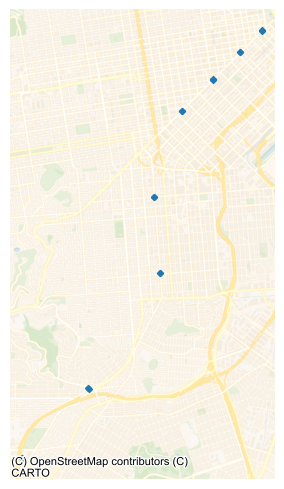

In [146]:
fig, ax = plt.subplots(figsize=(5, 5))
bart_stops.plot(ax=ax, markersize=9, marker="D")
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=bart_stops.crs)
ax.axis("off")
fig.tight_layout();

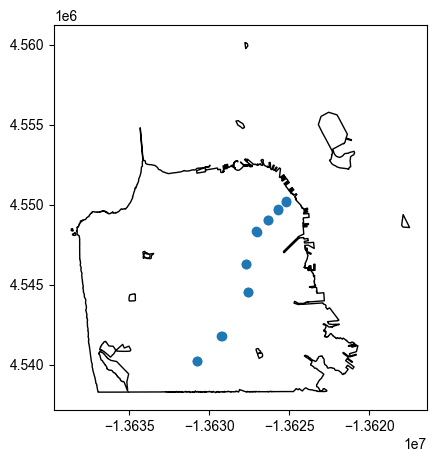

In [147]:
fig, ax = plt.subplots(figsize=(5, 5))
sf_no_water_web_map.plot(ax=ax, facecolor="none")
bart_stops.plot(ax=ax);

In [148]:
sf_bounds = sf_no_water_web_map.bounds.iloc[0]
sf_bounds

minx   -1.363863e+07
miny    4.538246e+06
maxx   -1.361748e+07
maxy    4.560119e+06
Name: 0, dtype: float64

In [149]:
sf_no_water_web_map.get_coordinates().std() * .2

x    1213.639688
y    1038.702216
dtype: float64

In [150]:
sf_bounds = sf_no_water_web_map.bounds.iloc[0]
sf_buffer = sf_no_water_web_map.get_coordinates().std() * .2

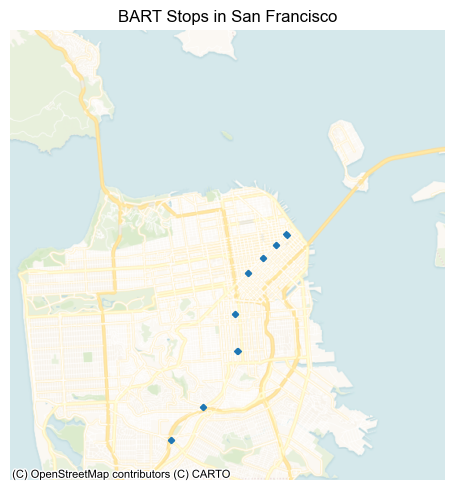

In [151]:
fig, ax = plt.subplots(figsize=(5, 5))
bart_stops.plot(ax=ax, markersize=9, marker="D")
# Use another shape to determine the zoom/map size
assert sf_no_water_web_map.crs == bart_stops.crs
sf_bounds = sf_no_water_web_map.bounds.iloc[0]
ax.set(xlim = (sf_bounds['minx'], sf_bounds['maxx']),
       ylim = (sf_bounds['miny'], sf_bounds['maxy'])
       )
ax.axis("off")
ax.set(title="BART Stops in San Francisco")
fig.tight_layout()
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=bart_stops.crs)

#### Open Street Maps Features with `osmnx`

In [171]:
sf_bart_web = ox.features.features_from_bbox(sf_no_water_web_map.to_crs("EPSG:4326").total_bounds,
                               {"railway": "subway"}).to_crs(sf_no_water_web_map.crs)
sf_bart_web.head(2)

geometry    name  \
element id                                                                    
way     24141635  LINESTRING (-13630727.47 4540516.258, -1363074...  M-Line   
        24141683  LINESTRING (-13630771.441 4540324.869, -136307...  M-Line   

                 network operator railway electrified frequency gauge layer  \
element id                                                                    
way     24141635    BART      NaN  subway        rail         0  1676    -1   
        24141683    BART      NaN  subway        rail         0  1676   NaN   

                 maxspeed                                          owner  \
element id                                                                 
way     24141635   36 mph  San Francisco Bay Area Rapid Transit District   
        24141683   36 mph  San Francisco Bay Area Rapid Transit District   

                 railway:preferred_direction tunnel voltage cutting level  \
element id                                                                  
way     24141635                     forward    yes    1000     NaN   NaN   
        24141683                     forward    NaN    1000     yes   NaN   

                 note wikipedia bridge service  
element id                                      
way     24141635  NaN       NaN    NaN     NaN  
        24141683  NaN       NaN    NaN     NaN

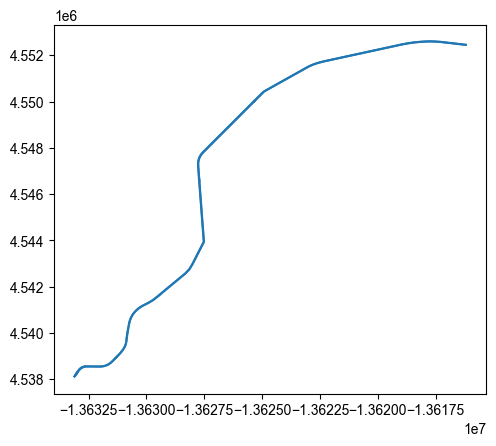

In [159]:
sf_bart_web.plot();

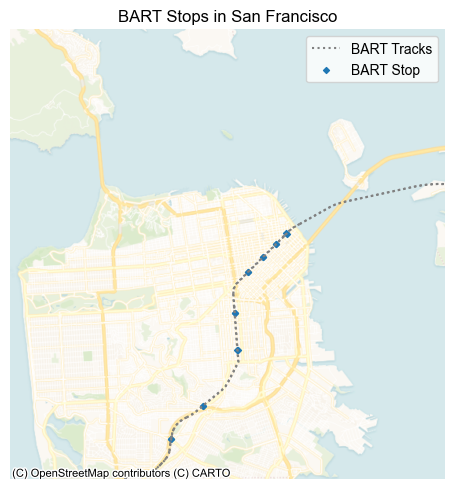

In [169]:
fig, ax = plt.subplots(figsize=(5, 5))
assert sf_no_water_web_map.crs == bart_stops.crs
sf_bounds = sf_no_water_web_map.bounds.iloc[0]
ax.set(xlim = (sf_bounds['minx'], sf_bounds['maxx']),
       ylim = (sf_bounds['miny'], sf_bounds['maxy'])
       )
ax.axis("off")
ax.set(title="BART Stops in San Francisco")
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=bart_stops.crs)
sf_bart_web.plot(ax=ax, linestyle=":", color="grey", label="BART Tracks")
bart_stops.plot(ax=ax, markersize=9, marker="D", label="BART Stop")
ax.legend()
fig.tight_layout()